<a href="https://colab.research.google.com/github/playpark95/PreSTAT433-2023_Observer2/blob/main/KU_%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%8A%A4%ED%84%B0%EB%94%94_1%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
x = np.random.rand(100, 1)
x.shape

(100, 1)

In [ ]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} seconds")
        return result
    return wrapper

In [ ]:
true_b = 1
true_w = 2
N = 100 # number of data

np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = 0.1 * np.random.randn(N, 1)
y = true_b + true_w * x + epsilon

In [ ]:
# Shuffles the indices
idx = np.arange(N)
split_index = int(N * 0.8) # train-validation split

train_idx = idx[:split_index]
val_idx = idx[split_index:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [ ]:
@timer
def train_model_numpy(lr=0.1, epochs=1000):

    # Initialize parameters
    b = np.random.randn(1)
    w = np.random.randn(1)

    for epoch in range(epochs):
        # Loss computation
        y_hat = b + w * x_train
        error = (y_hat - y_train)
        mse_loss = np.mean(error ** 2)

        # Gradient computation
        b_grad = 2 * np.mean(error)
        w_grad = 2 * np.mean(x_train * error)

        b = b - lr * b_grad
        w = w - lr * w_grad

    return b, w

In [ ]:
b_hat, w_hat = train_model_numpy()
print("b_estimate:{}, w_estimate: {}".format(b_hat, w_hat))

Execution time of train_model_numpy: 0.0705268383026123 seconds
b_estimate:[1.02341376], w_estimate: [1.93680725]


In [ ]:
import torch

In [ ]:
# create tensor at GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)

In [ ]:
@timer
def train_model_torch(lr=0.1, epochs=1000):

    # Initialize parameters
    b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
    w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

    for epoch in range(epochs):
        # Loss computation
        y_hat = b + w * x_train_tensor
        error = (y_hat - y_train_tensor)
        mse_loss = torch.mean(error ** 2)

        # Gradient computation
        mse_loss.backward()

        # Warning: this makes training extremly slow and memory inefficienty
        b = b - lr * b.grad
        w = w - lr * w.grad

        # Auxiliary code
        b.retain_grad(), w.retain_grad()

    return b, w

In [ ]:
b_hat, w_hat = train_model_torch(epochs=10)
print("b_estimate:{}, w_estimate: {}".format(b_hat, w_hat))

Execution time of train_model_torch: 0.01446676254272461 seconds
b_estimate:tensor([1.4763], grad_fn=<SubBackward0>), w_estimate: tensor([0.7159], grad_fn=<SubBackward0>)


In [ ]:
!pip install torchviz

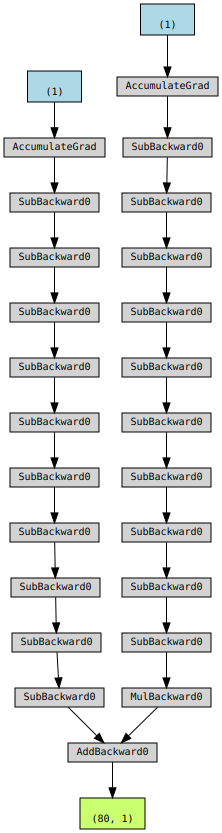

In [ ]:
from torchviz import make_dot
y_hat = b_hat + w_hat * x_train_tensor
make_dot(y_hat)

In [ ]:
@timer
def train_model_torch(lr=0.1, epochs=1000):

    # Initialize parameters
    b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
    w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

    for epoch in range(epochs):
        # Loss computation
        y_hat = b + w * x_train_tensor
        error = (y_hat - y_train_tensor)
        mse_loss = torch.mean(error ** 2)

        # Gradient computation
        mse_loss.backward()

        # Perform python operation without affecting computation graph
        with torch.no_grad():
            # in-place operation
            b -= lr * b.grad
            w -= lr * w.grad

        b.grad.zero_()
        w.grad.zero_()

    return b, w

In [ ]:
b_hat, w_hat = train_model_torch()
print("b_estimate:{}, w_estimate: {}".format(b_hat, w_hat))

Execution time of train_model_torch: 0.5316047668457031 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate: tensor([1.9368], requires_grad=True)


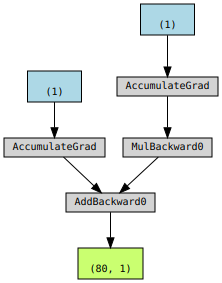

In [ ]:
y_hat = b_hat + w_hat * x_train_tensor
make_dot(y_hat)

In [ ]:
import torch.optim as optim
import torch.nn as nn

@timer
def train_model_torch_optim(lr=0.1, epochs=1000):

    # Initialize parameters
    b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
    w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
    parameters = [b, w]

    optimizer = optim.SGD(parameters, lr=lr)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        # Loss computation
        y_hat = b + w * x_train_tensor + w2 * (x_train_tensor ** 2)
        loss = mse_loss(y_hat, y_train_tensor)

        # Standard PyTorch code for training
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return b, w

In [ ]:
b_hat, w_hat = train_model_torch_optim()
print("b_estimate:{}, w_estimate: {}, w2_estimate: {}".format(b_hat, w_hat))

Execution time of train_model_torch_optim: 0.5560269355773926 seconds
b_estimate:tensor([1.2288], requires_grad=True), w_estimate: tensor([0.6651], requires_grad=True), w2_estimate: tensor([1.2529], requires_grad=True)
